# 🏗️ Viga de Bernoulli — PINN com PyTorch

## 🎯 Objetivo
Este notebook tem como objetivo resolver o problema de flexão de uma viga de Bernoulli utilizando Redes Neurais Físicas (PINN - Physics-Informed Neural Networks) implementadas em PyTorch.

## 📚 Descrição do Problema
Resolvemos a equação diferencial da flexão da viga de Bernoulli, levando em conta as condições de contorno especificadas no enunciado.

A equação diferencial clássica para uma viga de Bernoulli é:

$$
EI \cdot \frac{d^4w}{dx^4} = q(x)
$$

Onde:
- \(E\) = módulo de elasticidade
- \(I\) = momento de inércia
- \(w(x)\) = deslocamento transversal
- \(q(x)\) = carga distribuída (pode ser constante ou função de x)

## 🔗 Metodologia
- Definir a rede neural para estimar o deslocamento \(w(x)\).
- Construir a função de perda baseada na equação diferencial e nas condições de contorno.
- Otimizar os pesos da rede para minimizar essa perda.

---


In [7]:
# 📦 Importando bibliotecas
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# Dados do problema
L = 1.0   # Comprimento da viga (m)
E = 210e9 # Módulo de Elasticidade (Pa)
I = 1e-6  # Momento de inércia (m^4)
q = 1000  # Carga distribuída (N/m)

# Domínio - Pontos internos
x_interior = torch.linspace(0, L, 100).view(-1,1).requires_grad_(True)


In [9]:
class RedePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
def funcao_perda(modelo):

    # 🎯 Equação diferencial
    w = modelo(x_interior)

    w_x = torch.autograd.grad(w, x_interior, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_xx = torch.autograd.grad(w_x, x_interior, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_xxx = torch.autograd.grad(w_xx, x_interior, grad_outputs=torch.ones_like(w_xx), create_graph=True)[0]
    w_xxxx = torch.autograd.grad(w_xxx, x_interior, grad_outputs=torch.ones_like(w_xxx), create_graph=True)[0]

    # Equação da viga
    eq = E * I * w_xxxx - q

    perda_eq = torch.mean(eq**2)

    # 🎯 Condições de Contorno
    # x = 0
    x_0 = torch.tensor([[0.0]], requires_grad=True)
    w_0 = modelo(x_0)
    w_0_x = torch.autograd.grad(w_0, x_0, grad_outputs=torch.ones_like(w_0), create_graph=True)[0]

    # x = L
    x_L = torch.tensor([[L]], requires_grad=True)
    w_L = modelo(x_L)
    w_L_x = torch.autograd.grad(w_L, x_L, grad_outputs=torch.ones_like(w_L), create_graph=True)[0]
    w_L_xx = torch.autograd.grad(w_L_x, x_L, grad_outputs=torch.ones_like(w_L_x), create_graph=True)[0]
    w_L_xxx = torch.autograd.grad(w_L_xx, x_L, grad_outputs=torch.ones_like(w_L_xx), create_graph=True)[0]

    # Perda de condições de contorno
    perda_bc = w_0**2 + w_0_x**2 + w_L_xx**2 + w_L_xxx**2

    # 🎯 Perda total
    return perda_eq + perda_bc


In [11]:
modelo = RedePINN()
opt = torch.optim.Adam(modelo.parameters(), lr=0.01)

hist = []

for epoca in range(5000):
    opt.zero_grad()
    perda = funcao_perda(modelo)
    perda.backward()
    opt.step()

    hist.append(perda.item())

    if epoca % 500 == 0:
        print(f'Época {epoca} - Perda: {perda.item():.6f}')


Época 0 - Perda: 10466146304.000000
Época 500 - Perda: 3938.609375
Época 1000 - Perda: 3049.160156
Época 1500 - Perda: 2084.385010
Época 2000 - Perda: 1238.630005
Época 2500 - Perda: 626.921265
Época 3000 - Perda: 270.263062
Época 3500 - Perda: 109.619934
Época 4000 - Perda: 89.647972
Época 4500 - Perda: 169.972031


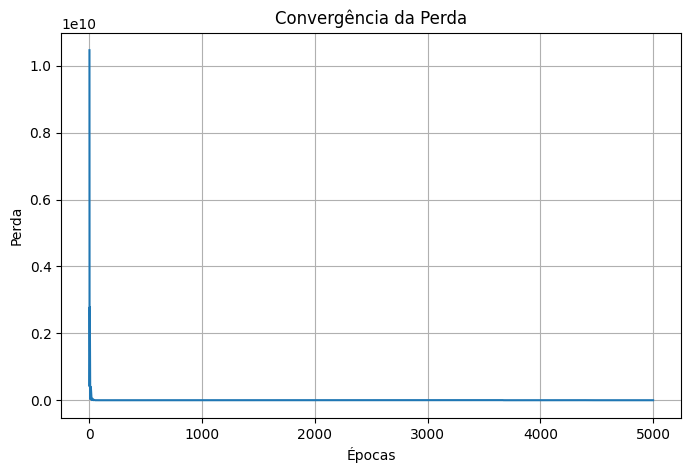

In [12]:
plt.figure(figsize=(8,5))
plt.plot(hist)
plt.title('Convergência da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid()
plt.show()


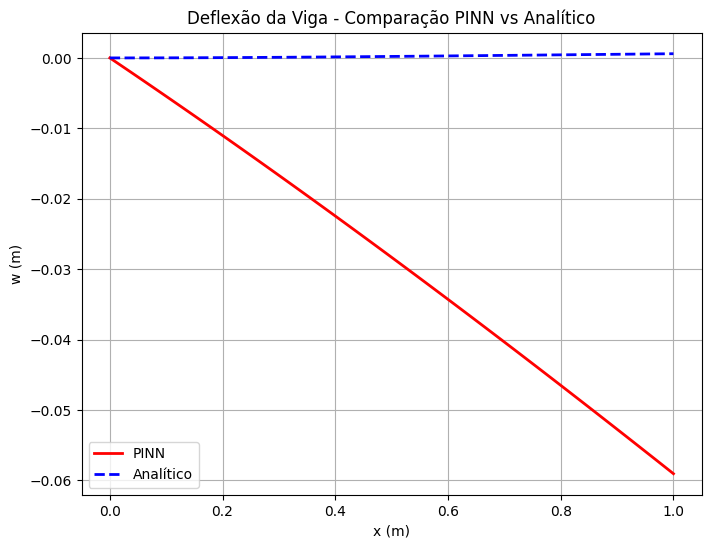

In [13]:
# Pontos para avaliação
x_plot = torch.linspace(0, L, 100).view(-1,1).requires_grad_(False)
w_pred = modelo(x_plot).detach().numpy()

# Solução analítica
x_np = x_plot.detach().numpy()
w_analitico = (q * x_np**2 / (24 * E * I)) * (x_np**2 - 4*L*x_np + 6*L**2)

plt.figure(figsize=(8,6))
plt.plot(x_np, w_pred, label='PINN', color='red', linewidth=2)
plt.plot(x_np, w_analitico, '--', label='Analítico', color='blue', linewidth=2)
plt.title('Deflexão da Viga - Comparação PINN vs Analítico')
plt.xlabel('x (m)')
plt.ylabel('w (m)')
plt.legend()
plt.grid()
plt.show()


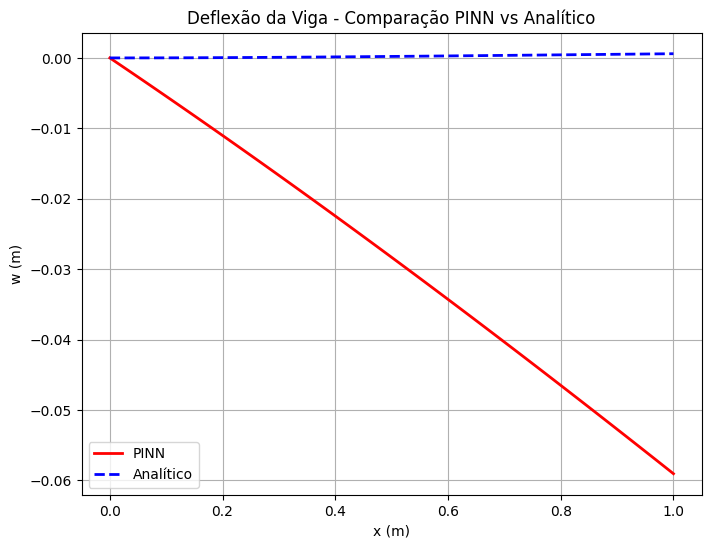

In [14]:
plt.figure(figsize=(8,6))
plt.plot(x_np, w_pred, label='PINN', color='red', linewidth=2)
plt.plot(x_np, w_analitico, '--', label='Analítico', color='blue', linewidth=2)
plt.title('Deflexão da Viga - Comparação PINN vs Analítico')
plt.xlabel('x (m)')
plt.ylabel('w (m)')
plt.legend()
plt.grid()
plt.savefig('../imagens/Viga_Bernoulli.png', dpi=300)
plt.show()
